# Imports

In [2]:
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataset import build_corpus

/home/lorenzo/anaconda3/envs/pix2pix/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Configuration

In [23]:
SIZE = 25000
MODEL_NAME = 'model_25k_300_8_10_1'
RELATIONS_CSV = 'questions-words.csv'

model = Word2Vec.load(f'models/{MODEL_NAME}.model')

# Word analogies

In [16]:
def check_relation(row, model):
    try:
        word_one = row['word_one']
        word_two = row['word_two']
        word_three = row['word_three']
        word_four = row['word_four']
        
        predicted_vector = model.wv[word_two] - model.wv[word_one] + model.wv[word_three]

        most_similar = model.wv.similar_by_vector(predicted_vector, topn=5)
        words_only = [word for word, similarity in most_similar]

        return word_four in words_only, most_similar[0][0]
    except KeyError:
        return None, None

def process_relations(df, model):
    results = []

    for _, row in df.iterrows():
        is_correct, predicted_word = check_relation(row, model)
        if predicted_word is not None:
            results.append({
                'row_id': row['row_id'],
                'category': row['category'],
                'word_one': row['word_one'],
                'word_two': row['word_two'],
                'word_three': row['word_three'],
                'word_four': row['word_four'],
                'is_correct': is_correct,
                'predicted_word': predicted_word
            })

    return pd.DataFrame(results)

csv_df = pd.read_csv(RELATIONS_CSV)
df = process_relations(csv_df, model)

word_analogy_acc = df['is_correct'].astype(int).sum()/len(df)

# KL divergence

In [25]:
arq = open(f'kl-{SIZE}.txt', 'r')
content = arq.read()
arq.close()

kl_divergences = eval(content)

In [26]:
data = build_corpus(SIZE, return_fields=['corpus', 'word2idx', 'idx2word', 'word_count'],  load=True)
corpus, w2idx, idx2w, wc = data['corpus'], data['word2idx'], data['idx2word'], data['word_count']
filtered_words = {key: value for key, value in wc.items() if value >=10}

## Visualizing the relation

In [30]:
def norm(embedding):
    return np.linalg.norm(embedding)

data = [(norm(model.wv[word]) if word in model.wv else 0, kl_divergences[word]) for word in filtered_words.keys()]

y = [data[i][1] for i in range(len(data)) if data[i][0] != 0]
x = [data[i][0] for i in range(len(data)) if data[i][0] != 0]

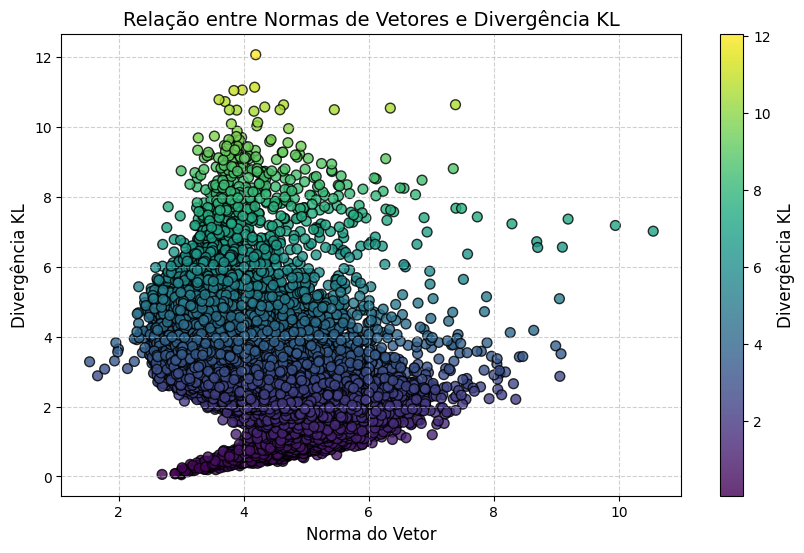

In [31]:
plt.figure(figsize=(10, 6))

scatter = plt.scatter(x, y, c=y, cmap='viridis', alpha=0.8, edgecolors='k', s=50)

plt.title("Relação entre Normas de Vetores e Divergência KL", fontsize=14)
plt.xlabel("Norma do Vetor", fontsize=12)
plt.ylabel("Divergência KL", fontsize=12)

cbar = plt.colorbar(scatter)
cbar.set_label("Divergência KL", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [39]:
with open(f'log/log-{MODEL_NAME}.txt', 'w') as f:
    f.write(f"*{MODEL_NAME}*\n")
    f.write(f"Word analogies accuracy: {word_analogy_acc:.2%}, {df['is_correct'].astype(int).sum()}/{len(df)}\n")
    f.write(f"Analogies CSV total len: {len(csv_df)}\n")

## Regression

In [33]:
from sklearn.linear_model import LinearRegression

In [16]:
X = [item[0] for item in data]  # Todos os valores de norm(model.wv[word])
y = [item[1] for item in data]

In [ ]:
regression_model = LinearRegression()
regression_model.fit(np.array(X).reshape(-1, 1), y)

In [ ]:
print("Coeficiente:", regression_model.coef_)